In [116]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
%matplotlib inline
from matplotlib import pyplot as plt

from alice.config import PROCESSING_INPUT_DIR
from alice.predict import predict_masks
from alice.visualise import visualise_mask
from alice.utils import *
from collections import OrderedDict
from itertools import zip_longest
from imutils import perspective
from typing import List
from operator import attrgetter

In [2]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [68]:
paths = [PROCESSING_INPUT_DIR / f'011245996_additional_{i}.jpeg' for i in range(1,5)]

# paths = [PROCESSING_INPUT_DIR / f'Tri434014_additional_{i}.JPG' for i in range(1,5)]



In [69]:
class Quadrilateral:
    def __init__(self, vertices):
        # Closest point to the bottom of the canvas
        self.closest_point = self.get_closest_point(vertices)
        
        # Vertices are assigned to a,b,c,d
        # A will be the closest point (with the maximum y value), with the points
        # ordered counter clockwise, with b being the next corner counter clockwise
        # A & C will be opposite each other; B & D opposite
        self.vertices = OrderedDict(zip(['a', 'b', 'c', 'd'], iter_list_from_value(vertices, self.closest_point)))
        
        # Loop through vertices, creating edges names a_b, b_c etc.,
        self.edges = OrderedDict([(
            f'{k1}_{k2}', LineString([
                self.vertices[k1], 
                self.vertices[k2]
            ])) for k1, k2 in pairwise(list(self.vertices.keys()))
        ])
        self.angles = self.get_corner_angles()

    @staticmethod
    def get_closest_point(vertices):
        """
        Get point with lowest y value
        """
        vertices = np.array(vertices)
        return tuple(vertices[np.argmax(vertices[:, 1])])        

    def get_corner_angles(self):
        angles = {}
        for e1, e2 in pairwise(list(self.edges.keys())):
            # The corner will be duplicated by the edge names: tl_tr, tr_br => tr
            vertice = Counter(e1.split('_') + e2.split('_')).most_common(1)[0][0]
            angles[vertice] = calculate_angle_between_lines(self.edges[e1], self.edges[e2])  
        return angles

    def is_wellformed_label_shape(self):
        """
        Validate the label shape, 4 corners & opposite angles be within 15 degrees
        """
        valid_angle = 15
        if len(self.vertices) != 4:
            return False
        oppos_corners = [('a', 'c'), ('b', 'd')]
        max_angle_diff = max([abs(self.angles[i] - self.angles[j]) for i,j in oppos_corners])  
        return max_angle_diff < valid_angle

    def visualise(self, image):
        for edge in self.edges.values():
            p = np.array(edge.coords).astype(np.int32)
            cv2.line(image, p[0], p[1], (0, 255, 0), 5)
        for point in self.vertices.values():
            pt = np.array(point).astype(np.int32)
            cv2.circle(image, pt, 5, (255,0,0), 5)
        return image

class Mask():
    def __init__(self, data: np.array):
        self._data = data

    @property
    def height(self):
        return self._data.shape[0]

    @property
    def width(self):
        return self._data.shape[1]  

    @property
    def y_midpoint(self):
        """
        Vertical midpoint of a mask
        """        
        return sum([min(np.where(self._data == True)[0]), max(np.where(self._data == True)[0])]) / 2 
        
    def contour(self, epsilon=5):
        contours, _ = cv2.findContours(self._data.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Simplify contour - otherwise approx_best_fit_ngon takes many seconds
        # Requires low epsilon < 10 otherwise approx vertices are out
        if epsilon:
            contours = cv2.approxPolyDP(contours[0], epsilon, True)        
        return contours

    def edges(self) -> np.array:
        """
        Get edges of a mask
        """
        # Diff will reduce width by 1, so prepend with extra column of 0s
        return np.diff(self._data, prepend=np.zeros(self.height)[0])  

    def edge_points(self) -> List:   
        """
        Get the edges 
        """    
        # Find the indices of True values in the mask, and return row col (points)
        return [(col, row) for row, col in np.argwhere(self.edges())]  

    def to_quadrilateral(self):
        """
        Get quadrilateral around mask
        """
        vertices = approx_best_fit_ngon(self.contour())
        quad = Quadrilateral(vertices)
        if quad.is_wellformed_label_shape():        
            return quad
        
        # TODO: Log
        # We want to get the two edges intersection at point A (closest corner)
        closest_edges = [quad.edges[e] for e in ['a_b', 'd_a']]
        vertices = approx_quadrilateral_from_closest_edges(closest_edges, self)
        approx_quad = Quadrilateral(vertices)
        if approx_quad.is_wellformed_label_shape():
            return approx_quad  

        # TODO: Log 

class AngledView():

    """
    A view of the specimen 
    """

    min_mask_size = 1500
    
    def __init__(self, path: Path):
        # FIXME: Reading image twice
        self.image = cv2.imread(str(path))
        self.predictions = predict_masks(path)
        self.masks = self.masks_from_predictions(self.predictions)
        self.boxes = self.masks_to_quadrilaterals()

    def masks_from_predictions(self, predictions):
        masks = self.predictions.get('instances').to("cpu").pred_masks.numpy()
        masks = self.filter_small_masks(masks)
        masks = self.remove_overlaps(masks)
        masks = [Mask(m) for m in masks]
        # Sort by mask y midpoint
        masks.sort(key = attrgetter('y_midpoint'))
        return masks

    def masks_to_quadrilaterals(self):
        return [mask.to_quadrilateral() for mask in self.masks]
                
    def filter_small_masks(self, masks: np.array):
        return [m for m in masks if np.count_nonzero(m) > self.min_mask_size]

    def remove_overlaps(self, masks: np.array):
        # FIXME: Doesn't work in Ariana's code
        return masks

    def __len__(self):
        return len(self.masks)

class Specimen():
    def __init__(self, paths: List[Path]):
        self.views = [AngledView(p) for p in paths]
        # TODO: Get the mean of the mask count, and drop any views not corresponding to mean
        # TODO: Log error

    def __iter__(self):
        for view in self.views:
            yield view

    def __len__(self):
        return len(self.views)

    def __getitem__(self, i):
        return self.views[i]

      

specimen = Specimen(paths)

In [70]:
view = specimen[0]

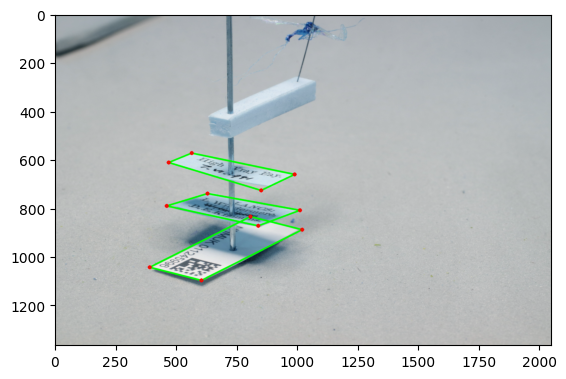

In [71]:
img = deepcopy(view.image)
for box in view.boxes:
    img = box.visualise(img)
plt.imshow(img)
plt.show()        


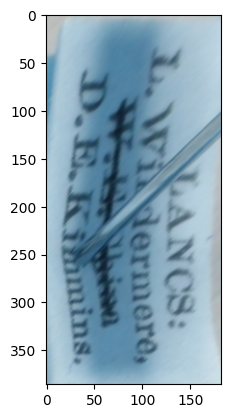

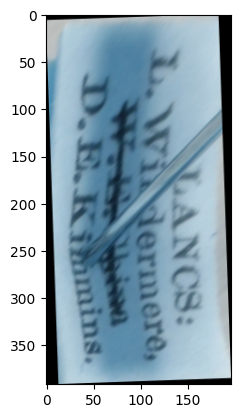

Page number: 0
Orientation in degrees: 270
Rotate: 90
Orientation confidence: 0.34
Script: Devanagari
Script confidence: 2.00



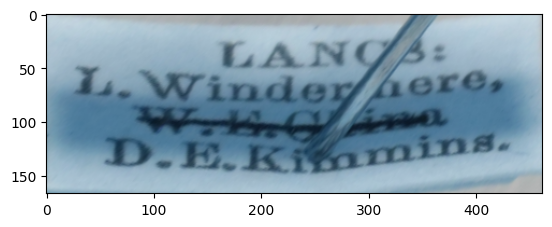

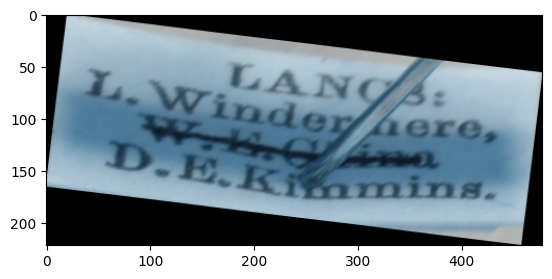

Page number: 0
Orientation in degrees: 180
Rotate: 180
Orientation confidence: 0.03
Script: Cyrillic
Script confidence: 3.33



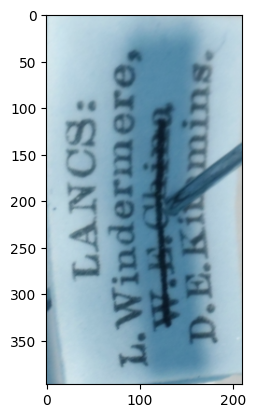

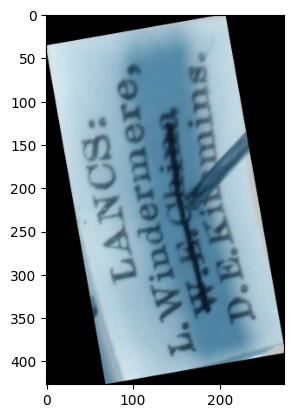

Page number: 0
Orientation in degrees: 90
Rotate: 270
Orientation confidence: 0.06
Script: Devanagari
Script confidence: 0.00



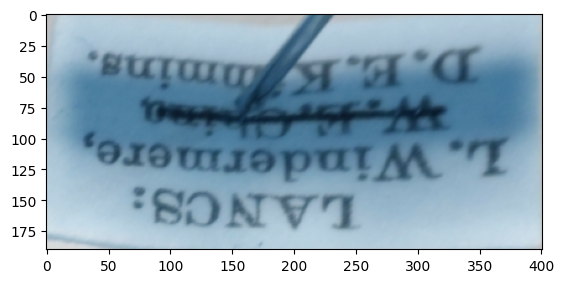

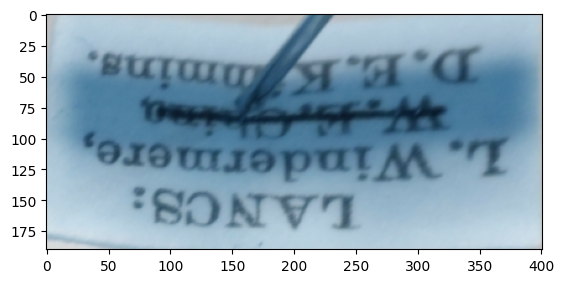

Page number: 0
Orientation in degrees: 0
Rotate: 0
Orientation confidence: 0.12
Script: Latin
Script confidence: 0.00



In [121]:
import imutils
img = deepcopy(view.image)

box = view.boxes[0]

def removeReps(T, F):
    # Remove repeated points in a curve.
    n = len(T)
    newT = []
    newF = []
    newT.append(T[0])
    newF.append(F[0])
    k = 0
    for i in range(1, n):
        if (T[i] != newT[k]) or (F[i] != newF[k]):
            newT.append(T[i])
            newF.append(F[i])
            k = k + 1
    return newT, newF

def warp_label(image, box):

    max_x = round(max([box.edges['a_b'].length, box.edges['c_d'].length])) - 1
    max_y = round(max([box.edges['b_c'].length, box.edges['d_a'].length])) - 1
    
    dest = np.float32([
        (0, max_x), #A
        (0, 0), #B
        (max_y, 0), #C
        (max_y, max_x) #D
    ])
    
    src = np.float32(list(box.vertices.values()))
    M = cv2.getPerspectiveTransform(src, dest)
    
    return cv2.warpPerspective(image,M,(max_y, max_x),flags=cv2.INTER_LINEAR)

def basic_threshold(img, p):
    # Global thresholding on a grey-scaled images based on a threshold value, p.
    if np.max(img) < 2:  # Assumes colour map is either between 0-1, or 0-255.
        mx = 1
    else:
        mx = 255
    thresh = deepcopy(img)
    thresh[np.where(img < p)] = 0
    thresh[np.where(img >= p)] = mx

    return thresh

def reject_outliers(data, index, m=10):
    # Function used to remove outliers from arrays. This is based on the median of the data.
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else 0.0
    inds = np.where(s < m)[0]
    if len(index) != 0:
        return data[inds], index[inds]
    else:
        return data[inds]    

def adjust_alignment(
    image_orig,
    angles=np.linspace(-10, 10, 21),
    percentile=15,
    min_contour_height=15,
    height_prop=30,
    return_col=False,
):

    k = 0

    opt_angle = 0
    max_len = 0
    max_ind = 0

    all_lens = []

    # Convert image to greyscale:
    image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
    # Compute threshold value based on percentile (not including black pixels):
    bound = np.percentile(
        image.flatten()[np.where(image.flatten() != 0)[0]], percentile
    )
    # Global thresholding:
    image_thresh = basic_threshold(image, bound)

    for i, angle in enumerate(angles):
        # Rotate image based on angle:
        seg = imutils.rotate_bound(image_thresh, angle)
        # Find contours:
        contours = measure.find_contours(seg, 0.8)
        # Filter for contours whose number of points isn't an outlier. This step is required to remove
        # contours around the label hence the aim is to get the contours of characters only.
        lens_ = [len(c[:, 0]) for c in contours]
        _, inds = reject_outliers(
            np.array(lens_), np.int_(np.linspace(0, len(lens_) - 1, len(lens_)))
        )
        # Save y coordinates of filtered contours:
        min_height = min([min_contour_height, np.shape(image)[0] / height_prop])
        all_y = []
        for i in inds:
            c = contours[i]
            x = c[:, 1]
            y = c[:, 0]
            if (len(x) > 10) & (
                (max(y) - min(y)) > min_height
            ):  # We focus on contours > 10 points. This number was chosen arbitrarily to exclude illegible/"accidental" contours.
                # Remove repeated points in contour.
                x, y = removeReps(np.round(x), np.round(y))
                all_y.extend(y)
        # Find number of points from the contours that lie in each horizontal strip across the thresholded image.
        lens = [
            len(np.where(np.array(all_y) == p)[0]) for p in range(0, np.shape(seg)[1])
        ]
        # Compute maximum across the horizontal strips.
        v = np.argmax(lens)
        m = max(lens)
        all_lens.append(lens)
        if m > max_len:
            max_len = deepcopy(m)
            max_ind = deepcopy(v)
            opt_angle = deepcopy(angle)

    rotated_img = imutils.rotate_bound(image, opt_angle)
    if return_col == True:
        return imutils.rotate_bound(image_orig, opt_angle)
    else:
        return opt_angle, max_len, max_ind, all_lens, rotated_img

warped_labels = []
for view in specimen:
    img = deepcopy(view.image)
    box = view.boxes[1]
    # img = box.visualise(img)
    # plt.imshow(img)
    # plt.show()      
    warped_label = warp_label(view.image, box)
    optimal_angle = adjust_alignment(warped_label, np.linspace(-10, 10, 21))[0]
    adjusted_label = imutils.rotate_bound(warped_label, optimal_angle)    
    plt.imshow(warped_label)
    plt.show()

    plt.imshow(adjusted_label)
    plt.show()

    x = pytesseract.image_to_osd(warped_label, config="--psm 0 -c min_characters_to_try=5 script=Latin",)
    print(x)    

    warped_labels.append(warped_label)


In [124]:
import pytesseract

def tesseract_orientation_with_binarization_thresholding(
    image, threshold_values=[30, 40, 50, 60]
):
    rotation_confidence_ = -1
    rotation_ = 0
    best_binarized_image = deepcopy(image)
    for thresh in threshold_values:
        bI = bin_image(image, bound_percentile=thresh)
        try:
            rotation, rotation_confidence = get_rotation_basic(bI)
            if rotation_confidence > rotation_confidence_:
                rotation_confidence_ = deepcopy(rotation_confidence)
                rotation_ = deepcopy(rotation)
                best_binarized_image = deepcopy(bI)
        except:
            # raise
            pass

    return rotation_[0], rotation_[1], rotation_confidence_, best_binarized_image


def get_rotation_basic(image, values=np.int_(np.linspace(3, 10, 8))):

    osd_, _ = get_osd(image, values)
    rotation_confidence = get_osd_confidence(osd_)
    rotation = np.int_(re.findall("\d+", osd_)[1:3])

    return rotation, rotation_confidence


def get_osd(image, min_char_values):
    max_total = min(min_char_values)
    osd = "N/A"
    for j in min_char_values:
        try:
            osd = pytesseract.image_to_osd(
                image,
                config="--psm 0 -c min_characters_to_try=" + str(j) + " script=Latin",
            )
            max_total = j
        except:
            pass
    return osd, max_total


def get_osd_confidence(osd):
    k1 = re.search("Orientation confidence: ", osd).span()[1]
    k2 = re.search("\nScript", osd).span()[0]
    rot = osd[k1:k2]
    return float(rot)


def max_ocr_length_orientation(
    image, threshold_values=[30, 40, 50, 60], angles=[0, 90, 180, 270]
):
    ocr_longest = ""
    best_angle = -10
    for angle in angles:
        I = imutils.rotate_bound(image, angle)
        ocr_ = ""
        for thresh in threshold_values:
            try:
                bI = bin_image(I, bound_percentile=thresh)
                ocr_results = pytesseract.image_to_string(
                    bI, config="--psm 11 script=Latin"
                )
                ocr_res = " ".join(re.findall("\w+", ocr_results))
            except:
                ocr_res = ""
            if len(ocr_res) > len(ocr_):
                ocr_ = deepcopy(ocr_res)
        if len(ocr_) > len(ocr_longest):
            ocr_longest = deepcopy(ocr_)
            best_angle = deepcopy(angle)

    return best_angle

def bin_image(image_orig, bound_percentile=50):
    # Aim: threshold image based on median colour.

    # Input: image.
    # Output: binarized image.

    image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
    m = np.percentile(image.flatten(), bound_percentile)
    image2 = deepcopy(image)
    image2[np.where(image > m)] = 255
    image2[np.where(image < m)] = 0
    return image2

def adjust_and_rotate_warped_label(warped_label):
    # Input: warped label.
    # Output: Optimally rotated label.

    # 1) Minor adjustment in label angle:
    optimal_angle = adjust_alignment(warped_label, np.linspace(-10, 10, 21))[0]
    adjusted_label = imutils.rotate_bound(warped_label, optimal_angle)
    # 2) Check the orientation of label with an optimized tesseract orientation tool:
    # Note that as this method isn't up to standard yet, we only accept the orientation
    # based on additional criteria, which also includes a backup tool to predict orientation.
    # This backup tool simply rotates the images 0,90,180,270 degrees and counts the number of
    # letters in each binarized image, using tesseract.
    (
        orientation,
        angle_to_rotate,
        confidence,
        best_binarized_image,
    ) = tesseract_orientation_with_binarization_thresholding(adjusted_label)
    if (orientation == 180) or (confidence > 0.5):
        rotated_label = imutils.rotate_bound(adjusted_label, angle_to_rotate)
    else:
        new_orientation_angle = max_ocr_length_orientation(adjusted_label)
        if new_orientation_angle == angle_to_rotate:
            rotated_label = imutils.rotate_bound(adjusted_label, angle_to_rotate)
        else:
            rotated_label = deepcopy(adjusted_label)
    return rotated_label, best_binarized_image

rotated_labels = []
binarized_labels = []
    
for warped_label in warped_labels:
    rotated_label, binarized_label = adjust_and_rotate_warped_label(
        warped_label
    )
    rotated_labels.append(rotated_label)
    binarized_labels.append(binarized_label)




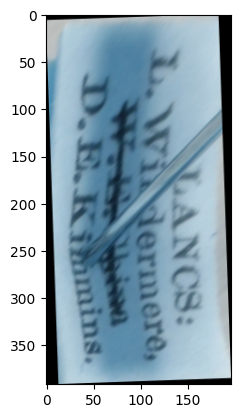

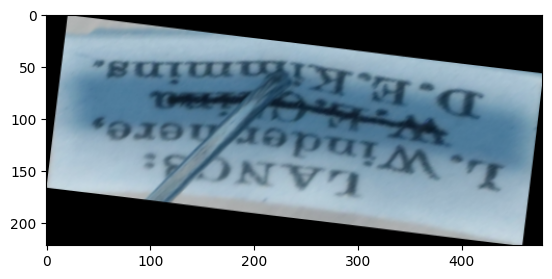

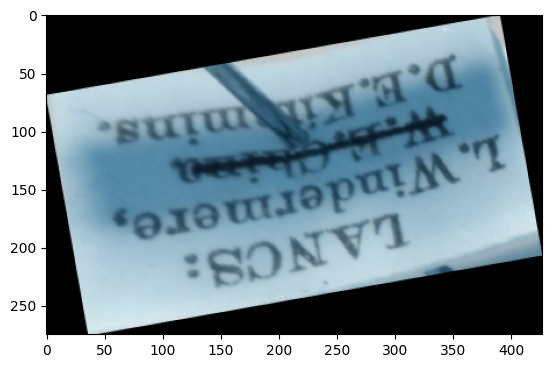

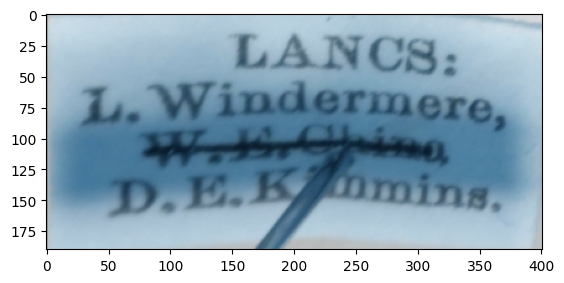

In [125]:
for rotated_label in rotated_labels:
    plt.imshow(rotated_label)
    plt.show()

In [127]:
def select_template_warped_label(all_rotated_warped_labels, all_binarized_labels):
    # Input: rotated_labels, binarized labels
    # Output: template based on one of the four rotated_labels.

    longest_label_text_length = 0
    template_warped_label = all_rotated_warped_labels[0]
    for ind, rotated_label in enumerate(all_rotated_warped_labels):
        binarized_label = all_binarized_labels[ind]
        ocr_results = pytesseract.image_to_string(
            binarized_label, config="--psm 11 script=Latin"
        )
        text_in_label = " ".join(re.findall("\w+", ocr_results))
        if len(text_in_label) > longest_label_text_length:
            longest_label_text_length = len(text_in_label)
            template_warped_label = deepcopy(rotated_label)
    return template_warped_label

template_warped_label = select_template_warped_label(
    rotated_labels, binarized_labels
)

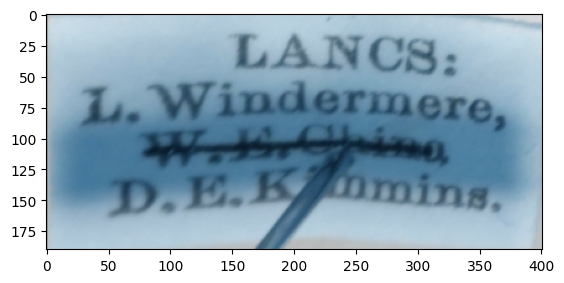

In [128]:
plt.imshow(template_warped_label)
plt.show()

In [138]:
def align_warped_label_to_template(
    image, template, matches_bound=0.9, max_no_matches=1000
):
    # Aim: align an image with a template.

    # Input: image / template.
    # Ouput: aligned image.

    img1_color = deepcopy(image)  # Image to be aligned.
    img2_color = deepcopy(template)  # Reference image.

    # Convert to grayscale.
    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
    height, width = img2.shape

    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(5000)

    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    #  (which is not required in this case).
    kp1, d1 = orb_detector.detectAndCompute(img1, None)
    kp2, d2 = orb_detector.detectAndCompute(img2, None)

    # Match features between the two images.
    # We create a Brute Force matcher with
    # Hamming distance as measurement mode.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match the two sets of descriptors.
    matches = matcher.match(d1, d2)

    # Sort matches on the basis of their Hamming distance.
    dists = [m.distance for m in matches]
    lst = [matches[i] for i in np.argsort(dists)]
    matches = tuple(lst)

    # Take the top 90 % matches forward.
    matches = matches[: int(len(matches) * matches_bound)]

    # Filter matches (ASJ edit):

    lines, new_index = filter_matches_new(matches, kp1, kp2, img1)

    lines_filtered = np.array(lines)[new_index]

    matches = tuple([m for i, m in enumerate(matches) if i in new_index])

    no_of_matches = len(matches)

    if no_of_matches > max_no_matches:
        matches = matches[:max_no_matches]
        no_of_matches = len(matches)
        lines_filtered = lines_filtered[:max_no_matches]

    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))

    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt

    # Find the homography matrix.
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

    # Use this matrix to transform the
    # colored image wrt the reference image.
    transformed_img = cv2.warpPerspective(img1_color, homography, (width, height))

    return transformed_img, lines, lines_filtered, homography

def filter_matches_new(matches, kp1, kp2, template_image):

    lines = get_matches(matches, kp1, kp2, template_image)

    gradients = []
    gradients_index = []
    for i, l in enumerate(lines):
        grad = get_grad(l)
        gradients.append(grad)
        gradients_index.append(i)
    try:
        LB, UB = outlier_bounds(gradients)
    except:
        LB, UB = [0, 0]

    pos_gradients_filtered_index = []
    neg_gradients_filtered_index = []

    for i, g in enumerate(gradients):
        if LB <= g <= UB:
            if g >= 0:
                pos_gradients_filtered_index.append(gradients_index[i])
            else:
                neg_gradients_filtered_index.append(gradients_index[i])

    all_new_index = [pos_gradients_filtered_index, neg_gradients_filtered_index]
    k = np.argmax([len(I) for I in all_new_index])
    gradients_filtered_index = all_new_index[k]

    return lines, gradients_filtered_index


def get_matches(matches, kp1, kp2, img):

    lines = []
    for v in range(len(matches)):
        i1, i2 = [matches[v].queryIdx, matches[v].trainIdx]
        x1 = kp1[i1].pt[0]
        y1 = kp1[i1].pt[1]
        x2 = kp2[i2].pt[0] + np.shape(img)[1]
        y2 = kp2[i2].pt[1]
        lines.append([[x1, x2], [y1, y2]])
    return lines


def get_grad(l):
    return np.round((l[1][1] - l[1][0]) / (l[0][1] - l[0][0]), 6)


def outlier_bounds(values, alpha=1.5):
    IQR_ = alpha * (np.percentile(values, 75) - np.percentile(values, 25))
    UB = np.percentile(values, 75) + IQR_
    LB = np.percentile(values, 25) - IQR_
    return LB, UB    

def align_warped_labels(all_rotated_warped_labels, template_warped_label):
    # Input: all rotated labels, template_label
    # Ouput: all labels aligned to template.
    aligned_labels = []
    for warped_label in all_rotated_warped_labels:
        if np.array_equal(warped_label, template_warped_label):
        # if warped_label == template_warped_label:
            aligned_labels.append(warped_label)
        else:
            try:
                aligned_label = align_warped_label_to_template(
                    warped_label, template_warped_label
                )[0]
                aligned_labels.append(aligned_label)
            except:
                raise
                pass

    if len(aligned_labels) == 0:
        aligned_labels = deepcopy(all_rotated_warped_labels)
    return aligned_labels

aligned_labels = align_warped_labels(rotated_labels, template_warped_label)

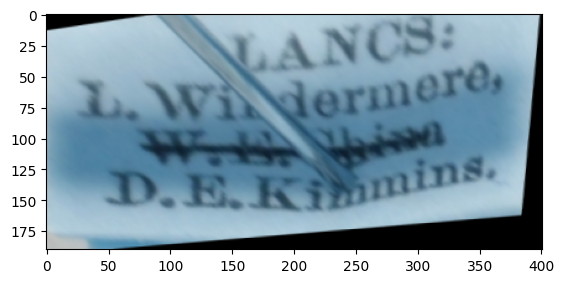

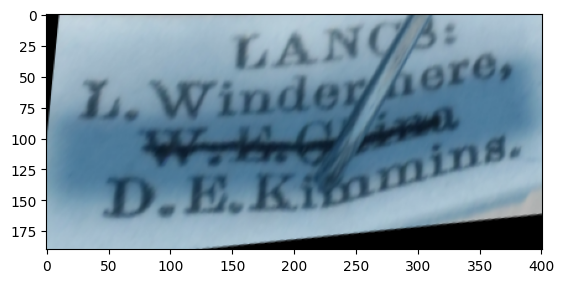

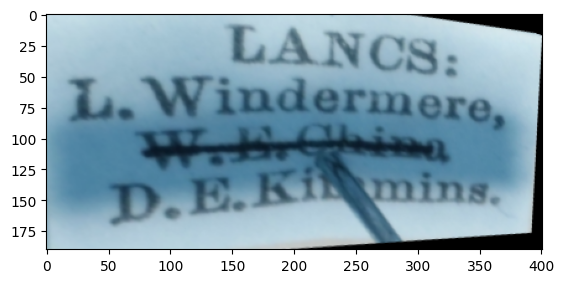

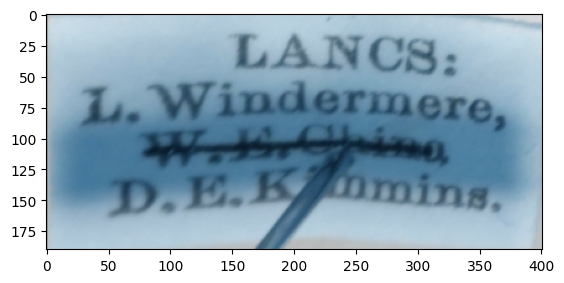

In [139]:
for rotated_label in aligned_labels:
    plt.imshow(rotated_label)
    plt.show()

In [144]:
def is_label_good(label):
    # Input: label
    # Output: classification of whether label is good or bad (np.bool).
    return True
    classification = good_or_bad_label_predictor(label)
    good_or_bad = classification["instances"].pred_classes[0].item()
    return np.bool(good_or_bad)


def exclude_bad_labels_with_template_pixel_difference(
    aligned_labels, template_warped_label
):
    # Input: aligned labels, template label.
    # Output: filtered labels (that are not too different from template).
    sum_of_pixel_differences_all = [
        np.sum(abs(template_warped_label - label)) for label in aligned_labels
    ]
    sum_of_pixel_differences = [
        diffsum for diffsum in sum_of_pixel_differences_all if diffsum > 0
    ]
    upper_bound_pixel_diffsum = np.median(sum_of_pixel_differences) + (
        np.percentile(sum_of_pixel_differences, 75)
        - np.percentile(sum_of_pixel_differences, 25)
    )
    filtered_aligned_labels = []
    for ind, label in enumerate(aligned_labels):
        if sum_of_pixel_differences_all[ind] < upper_bound_pixel_diffsum:
            filtered_aligned_labels.append(label)
    return filtered_aligned_labels

def find_all_good_labels(aligned_labels, template_warped_label):
    # Input: aligned labels
    # Output: good labels.
    try:
        filtered_aligned_labels = exclude_bad_labels_with_template_pixel_difference(
            aligned_labels, template_warped_label
        )
    except:
        filtered_aligned_labels = deepcopy(aligned_labels)
    filtered_labels = []
    for label in filtered_aligned_labels:
        if is_label_good(label) is True:
            filtered_labels.append(label)
    if len(filtered_labels) == 0:
        filtered_labels = deepcopy(aligned_labels)
    return filtered_labels

filtered_labels = find_all_good_labels(aligned_labels, template_warped_label)


In [146]:
def merge_label(all_labels, method=0):
    # Aim: merge multiple labels together.

    # Input: label images to merge.
    # Output: merged label.

    """
    Method 0 - original method by Ginger (https://github.com/NaturalHistoryMuseum/ALICE/blob/master/ALICE/models/viewsets.py#L38-L49)
    Method 1 - alternative method (darkest values per pixel)
    """

    if method == 0:
        I = np.median(np.stack([v for v in all_labels]), axis=0)
        merged_label = np.array(I, dtype="uint8")
    else:
        bw_images = []
        bw_images_mx = []
        for img in all_labels:
            image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            bw_images.append(image)
            image2 = deepcopy(image)
            image2[np.where(image == 0)] = 254
            bw_images_mx.append(image2)

        merged_label = np.min(bw_images_mx, 0)

    return merged_label

def merge_aligned_labels(filtered_labels):
    # Input: all filtered labels.
    # Output: merged label.
    try:
        merged_label = merge_label(filtered_labels, method=0)
    except:
        merged_label = merge_label(filtered_labels, method=1)
    return merged_label
    

merged_label = merge_aligned_labels(filtered_labels)

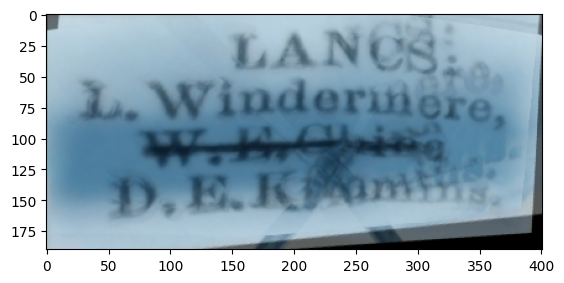

In [147]:
plt.imshow(merged_label)
plt.show()

In [109]:
from pytesseract import Output

x = pytesseract.image_to_osd(adjusted_label, config="--psm 0 -c min_characters_to_try=5 script=Latin",)
print(x)

Page number: 0
Orientation in degrees: 180
Rotate: 180
Orientation confidence: 0.01
Script: Katakana
Script confidence: 0.00



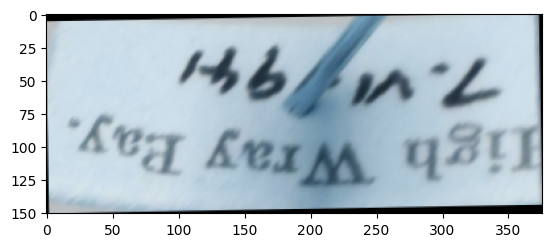

In [103]:
plt.imshow(adjusted_label)
plt.show()

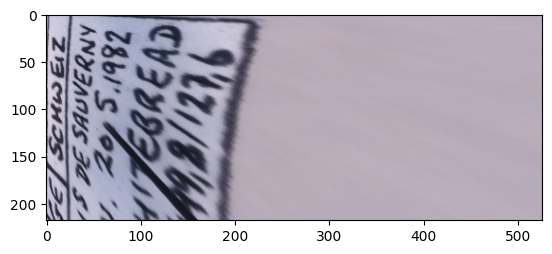

In [59]:
plt.imshow(x)
plt.show()

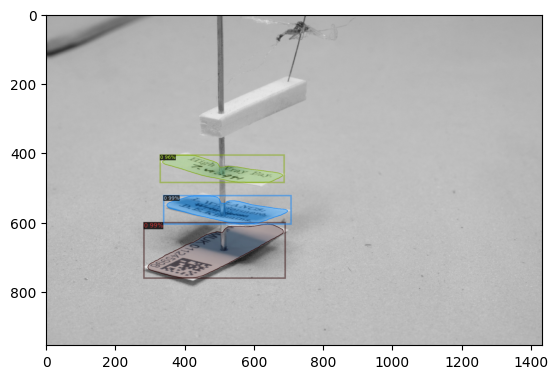

In [85]:
x = visualise_mask(view.image, view.predictions)
plt.imshow(x)
plt.show()

In [90]:
def approx_best_fit_ngon(contours, n: int = 4) -> list[(int, int)]:
    """

    https://stackoverflow.com/questions/41138000/fit-quadrilateral-tetragon-to-a-blob
    """

    hull = cv2.convexHull(contours)
    hull = np.array(hull).reshape((len(hull), 2))

    # to sympy land
    hull = [sympy.Point(*pt) for pt in hull]

    # run until we cut down to n vertices
    while len(hull) > n:
        best_candidate = None

        # for all edges in hull ( <edge_idx_1>, <edge_idx_2> ) ->
        for edge_idx_1 in range(len(hull)):
            edge_idx_2 = (edge_idx_1 + 1) % len(hull)

            adj_idx_1 = (edge_idx_1 - 1) % len(hull)
            adj_idx_2 = (edge_idx_1 + 2) % len(hull)

            edge_pt_1 = sympy.Point(*hull[edge_idx_1])
            edge_pt_2 = sympy.Point(*hull[edge_idx_2])
            adj_pt_1 = sympy.Point(*hull[adj_idx_1])
            adj_pt_2 = sympy.Point(*hull[adj_idx_2])

            subpoly = sympy.Polygon(adj_pt_1, edge_pt_1, edge_pt_2, adj_pt_2)
            angle1 = subpoly.angles[edge_pt_1]
            angle2 = subpoly.angles[edge_pt_2]

            # we need to first make sure that the sum of the interior angles the edge
            # makes with the two adjacent edges is more than 180°
            if sympy.N(angle1 + angle2) <= sympy.pi:
                continue

            # find the new vertex if we delete this edge
            adj_edge_1 = sympy.Line(adj_pt_1, edge_pt_1)
            adj_edge_2 = sympy.Line(edge_pt_2, adj_pt_2)
            intersect = adj_edge_1.intersection(adj_edge_2)[0]

            # the area of the triangle we'll be adding
            area = sympy.N(sympy.Triangle(edge_pt_1, intersect, edge_pt_2).area)
            # should be the lowest
            if best_candidate and best_candidate[1] < area:
                continue

            # delete the edge and add the intersection of adjacent edges to the hull
            better_hull = list(hull)
            better_hull[edge_idx_1] = intersect
            del better_hull[edge_idx_2]
            best_candidate = (better_hull, area)

        if not best_candidate:
            raise ValueError("Could not find the best fit n-gon!")

        hull = best_candidate[0]

    # back to python land
    hull = [(int(x), int(y)) for x, y in hull]

    return hull

mask = view.masks[2]
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Simplify contour - otherwise approx_best_fit_ngon takes many seconds
# Requires low epsilon < 10 otherwise approx vertices are out
epsilon = 5 
contours = cv2.approxPolyDP(contours[0], epsilon, True)

vertices = approx_best_fit_ngon(contours)

In [91]:
vertices

[(604, 1099), (395, 1046), (719, 879), (1090, 854)]

In [92]:
vertices

[(604, 1099), (395, 1046), (719, 879), (1090, 854)]

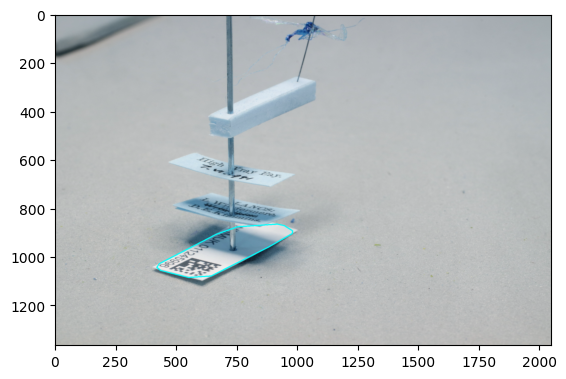

In [94]:
img = deepcopy(view.image)

hull = cv2.convexHull(contours)
cv2.drawContours(img, [hull], -1, (0,255,255), 3)

plt.imshow(img)
plt.show()

In [95]:
vertices

[(604, 1099), (395, 1046), (719, 879), (1090, 854)]

In [161]:
# Move to UTILS



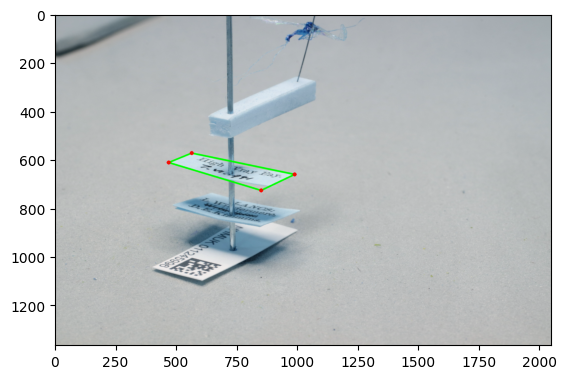

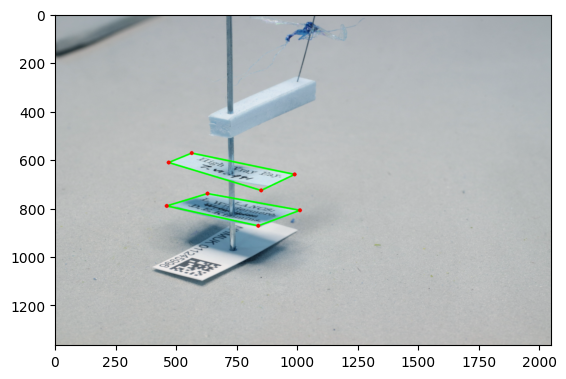

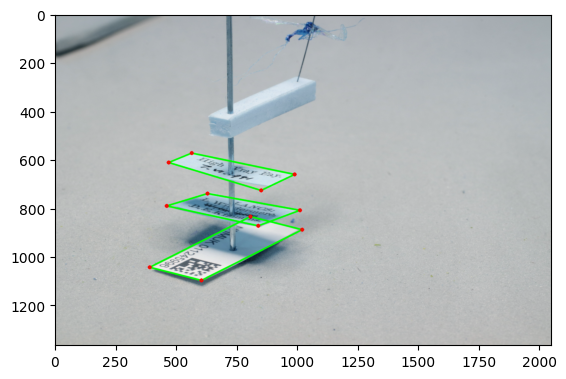

In [236]:

            
        





    # TODO: Log


img = deepcopy(view.image)





for view in specimen:
    img = deepcopy(view.image)
    for mask in view.masks:
        quad = mask_to_quadrilateral(mask)
        img = quad.visualise(img)
        plt.imshow(img)
        plt.show()        

    break
    
        # if not quad.is_wellformed_label_shape():

    
    # quad.angles['a']
    
    # print(quad.angles)
    # break

    # quad = Quadrilateral(vertices)

    # print(vertices)

    


    # closest_point = max(vertices, key= lambda x: vertices[x][1])  

    # x = cv2.convexHull(np.array(vertices), clockwise=False)

    # print(closest_point)

    # print(list(vertices))

    # for vertice in :
    #     print(vertice)

    # vertices = OrderedDict(zip(['a', 'b', 'c', 'd'], iter_list_from_value(vertices, closest_point)))        

    # print(closest_point)
    # print(vertices.index(closest_point))

    # print(x)

    # print(vertices)
    # break
    
    # print(type(x))

    


    # break
    
    # if quad.is_valid_label_shape():
    #     pass

    
    # print(mask)

# quad = Quadrilateral(vertices)

In [233]:
# for x in quad:
#     print(list(map(tuple, x)))



[(1018, 889), (603, 1098), (390, 1044), (805, 835)]

array([1189,  550])

In [28]:
quad.edges

OrderedDict([('tl_tr', <LINESTRING (1132 918, 1214 1074)>),
             ('tr_br', <LINESTRING (1214 1074, 1591 859)>),
             ('br_bl', <LINESTRING (1591 859, 1011 1011)>),
             ('bl_tl', <LINESTRING (1011 1011, 1132 918)>)])

In [41]:
import math 




    

tr
91.96749918287678
br
164.9894404319256
bl
157.13949584987
tl
99.81744376493239


'tl'